In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tweet_preprocess_mod as pre
from nltk.corpus import stopwords, twitter_samples

import csv
import numpy as np
import pandas as pd

from pandas import Series, DataFrame
import matplotlib.pyplot as plt

Hazır veriler:

In [3]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

Yardımcı fonksiyonlar:

In [4]:
def count_tweets(tweets: list, ys: list):
    """
    Calculates the words frequency and matches it with it's y value.
            
    Returns:
        freqs(dict): {(word, y): frequency}.
    """
    
    freqs = {}
    for y, tweet in zip(ys, tweets):
        clean_tweet = pre.process_tweet(tweet)
        for word in clean_tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs


def lookup(freqs: dict, word: str, label: int):
    """
    Looks up the given word's frequency.
    
    Returns:
        n(int): frequency.
    """
    n = 0
    pair = (word, label)
    if pair in freqs:
        n = freqs[pair]

    return n

In [5]:
freqs = count_tweets(train_x, train_y)

freqs[("happy", 1)]

150

Naive Bayes fonksiyonları:

In [6]:
def train_naive_bayes(freqs: dict, train_x: list, train_y: list):
    """
    Calculates the prior and the likelihood.
    """
    loglikelihood = {}
    logprior = 0

    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    N_pos = N_neg = 0
    for pair in freqs.keys():
        if pair[1] > 0:
            N_pos += freqs[pair]
        else:
            N_neg += freqs[pair]

    D = len(train_y)
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))
    logprior = np.log(D_pos) - np.log(D_neg)

    for word in vocab:
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)

        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [7]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

loglikelihood

{'wtf': -1.2957293305571722,
 'nudes': -0.6895935269868567,
 'surprise': 0.9198443854472436,
 'agent': 0.696700834133034,
 'tessnzach': 0.696700834133034,
 'genre': 0.696700834133034,
 'servus': 0.696700834133034,
 'kapima': 0.696700834133034,
 'andaming': -0.6895935269868567,
 'march': 0.003553653573088608,
 'lemon': 1.1021659422411982,
 'specialise': 1.612991566007189,
 'motor': -0.6895935269868567,
 'ganbarimasu': -0.6895935269868567,
 'usage': -0.6895935269868567,
 'meth': 0.696700834133034,
 'west': 0.003553653573088608,
 'netflix': -1.3827407075468021,
 'mcdo': 0.696700834133034,
 'anyare': -0.6895935269868567,
 'somehow': -1.095058635095021,
 'ariel': -0.6895935269868567,
 'excl': 0.696700834133034,
 'impressive': 0.696700834133034,
 'erm': -0.6895935269868567,
 'scout': 0.696700834133034,
 'follow': 0.0481858075938568,
 'winner': 1.3898480146929793,
 'band': 0.003553653573088608,
 'documentary': 0.696700834133034,
 'slowly': -0.6895935269868567,
 'deny': -0.6895935269868567,
 '

In [8]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    """
    Predicts the given tweet's sentiment 
    with the trained Naive Bayes classifier.
    """
    word_l = pre.process_tweet(tweet)
    p = 0
    p += logprior

    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]

    return p

In [9]:
tweet = "All those moments will be lost in time, \
        like tears in rain. Time to die."
print(naive_bayes_predict(tweet, logprior, loglikelihood))

tweet = "I hate being bipolar, it's awesome"
print(naive_bayes_predict(tweet, logprior, loglikelihood))

tweet = "It’s a good thing I don’t like spinach, \
        because if I did, I’d eat it, \
        and I can’t stand the stuff."
print(naive_bayes_predict(tweet, logprior, loglikelihood))


-5.037758362911392
0.14063869977069987
-0.3518458584444867


In [10]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    accuracy = 0

    y_hats = []
    for tweet in test_x:
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)

    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1 - error

    return accuracy

In [11]:
acc = test_naive_bayes(test_x, test_y, logprior, loglikelihood)
print(f"Accuracy: {acc:.2%}")

Accuracy: 99.15%


Naive Bayes algoritmasını kullanmadan, kelime frekansları ile pozitiflik/negatiflik oranı ölçen fonksiyonlar:

In [12]:
def get_ratio(freqs, word):
    pos_neg_ratio = {"positive": lookup(freqs, word, 1), 
                     "negative": lookup(freqs, word, 0), 
                     "ratio": 0.0}
    pos_neg_ratio["ratio"] = (pos_neg_ratio["positive"] + 1) / (pos_neg_ratio["negative"] + 1)

    return pos_neg_ratio


def get_words_by_threshold(freqs, label, threshold):
    word_list = {}

    for key in freqs.keys():
        word, _ = key
        pos_neg_ratio = get_ratio(freqs, word)

        if label == 1 and pos_neg_ratio["ratio"] >= threshold:
            word_list[word] = pos_neg_ratio
        elif label == 0 and pos_neg_ratio["ratio"] <= threshold:
            word_list[word] = pos_neg_ratio

    return word_list

In [13]:
get_words_by_threshold(freqs, 0, 1)

{'odd': {'positive': 1, 'negative': 1, 'ratio': 1.0},
 ':/': {'positive': 5, 'negative': 8, 'ratio': 0.6666666666666666},
 'please': {'positive': 78, 'negative': 242, 'ratio': 0.32510288065843623},
 'contact': {'positive': 4, 'negative': 7, 'ratio': 0.625},
 'centre': {'positive': 1, 'negative': 2, 'ratio': 0.6666666666666666},
 'able': {'positive': 6, 'negative': 17, 'ratio': 0.3888888888888889},
 'listen': {'positive': 13, 'negative': 14, 'ratio': 0.9333333333333333},
 'last': {'positive': 39, 'negative': 51, 'ratio': 0.7692307692307693},
 'get': {'positive': 223, 'negative': 271, 'ratio': 0.8235294117647058},
 'mark': {'positive': 1, 'negative': 2, 'ratio': 0.6666666666666666},
 'fb': {'positive': 3, 'negative': 4, 'ratio': 0.8},
 'long': {'positive': 28, 'negative': 35, 'ratio': 0.8055555555555556},
 'thought': {'positive': 4, 'negative': 4, 'ratio': 1.0},
 'enough': {'positive': 16, 'negative': 18, 'ratio': 0.8947368421052632},
 'time': {'positive': 97, 'negative': 123, 'ratio': 0

Using mined data:

In [14]:
def sentiment_saver(file_name_wo_ex: str):
    folder_path = "/mnt/nvme0n1p4/Users/Taner/PycharmProjects/Research/Data/Mined_Data/"
    txt_file_path = folder_path + file_name_wo_ex + ".txt"
    csv_file_path = folder_path + file_name_wo_ex + ".csv"
    f = open(txt_file_path, "r+", encoding="utf-8")
    g = open(csv_file_path, "w+", encoding="utf-8")

    label = 0

    lines = ["label\ttweet\n"] + f.readlines()
    f.seek(0)
    t=0
    for line in lines:
        if t == 0:
            g.write(line)
            t += 1
            continue
        
        
        if naive_bayes_predict(line, logprior, loglikelihood) >= 0:
            label = 1
        elif naive_bayes_predict(line, logprior, loglikelihood) <= 0:
            label = 0

        g.write(f"{label}\t{line[:-2]}\n")

    f.close()
    g.close()
    
    return pd.read_csv(csv_file_path, sep="\t")

In [15]:
df_2021 = sentiment_saver("full_data")

In [16]:
df_2021.head()

,label,tweet
0,0,@LandoPicks @TheMWGeddes @DebReyn85125570 @Ang...
1,1,@bethanyshondark Bethany did anyone tell you w...
2,1,@DonaldJTrumpJr May God Forgive Our Leaders fo...
3,1,@MarthavonRohr @JoyAnnReid My friend who is a ...
4,0,@MichaelGKagan @chrislhayes We trt Corona viru...


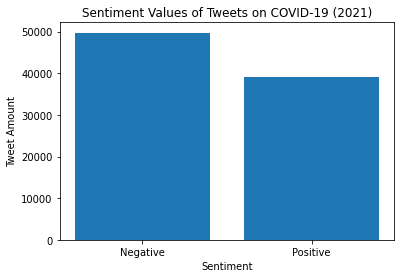

In [17]:
data = [sent_val for sent_val in df_2021["label"].value_counts()]
labels = ["Negative", "Positive"]
plt.xticks(range(len(data)), labels)
plt.xlabel("Sentiment")
plt.ylabel("Tweet Amount")
plt.title("Sentiment Values of Tweets on COVID-19 (2021)")
plt.bar(range(len(data)), data)
plt.show()

In [37]:
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print(f"{y}\t{int(np.sign(y_hat) > 0)}\t{' '.join(pre.process_tweet(x))}")

Truth Predicted Tweet
1.0	0	
1.0	0	truly lateral move know queen bee upward movingonup
1.0	0	wake feel incredibly sick idk cause drank starbucks o'clock last night reaction med :)
1.0	0	new report talk burn calorie cold work hard warm feel good weather :p
1.0	0	
1.0	0	wanna loser ♥
1.0	0	
1.0	0	park get sunlight
1.0	0	uff itna miss karhy thy ap :p
0.0	1	lot people suggest still
0.0	1	u probs fun david
0.0	1	hi unfortunately unable locate original complaint pls dm product detail we'll get back
0.0	1	fun osaka super junior lovely watch comeback stage
0.0	1	pat jay
0.0	1	give work old staff come police later court look job bye bye
0.0	1	carter deserve hate deserve single corn chip deserve corn chip
0.0	1	thats life get call people havent see year always favour
